In [1]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, round, when
from pyspark.sql.functions import sum as _sum
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType
from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer

# I. Xử lý đặc trưng

In [2]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("FeatureExtraction") \
    .getOrCreate()

## 1. Xử lý label và các đặc trưng trong bảng loan_status_history

In [3]:
loan_status_history_path = "hdfs://namenode:9000/bigdata/data/splitted_data/loan_status_history"

In [4]:
loan_status_history_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("loan_status", StringType(), True),
    StructField("pymnt_plan", StringType(), True),
    StructField("initial_list_status", StringType(), True),
    StructField("last_pymnt_d", StringType(), True),
    StructField("next_pymnt_d", StringType(), True),
    StructField("last_pymnt_amnt", DoubleType(), True),
    StructField("out_prncp", DoubleType(), True),
    StructField("out_prncp_inv", DoubleType(), True)
])

In [5]:
loan_status_history_df = (
    spark.read.option("header", True)
    .option("quote", '"')
    .option("escape", '"')
    .schema(loan_status_history_schema)
    .csv(loan_status_history_path)
)

### 1.1. Label

In [6]:
total_count = loan_status_history_df.count()
loan_status_history_df.groupBy("loan_status") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+---------------------------------------------------+------+-------+
|loan_status                                        |count |percent|
+---------------------------------------------------+------+-------+
|Current                                            |601482|67.86  |
|Fully Paid                                         |207306|23.39  |
|Charged Off                                        |45155 |5.09   |
|Late (31-120 days)                                 |11581 |1.31   |
|Issued                                             |8340  |0.94   |
|In Grace Period                                    |6251  |0.71   |
|Late (16-30 days)                                  |2355  |0.27   |
|Does not meet the credit policy. Status:Fully Paid |1894  |0.21   |
|Default                                            |1218  |0.14   |
|Does not meet the credit policy. Status:Charged Off|727   |0.08   |
+---------------------------------------------------+------+-------+



#### Nhận thấy có 2 status: Does not meet the credit policy. Status:Fully Paid và Does not meet the credit policy. Status:Charged Off, có thể gộp hai cột này vào các cột Fully Paid và Charged Off

In [7]:
loan_status_history_df = loan_status_history_df.withColumn(
    "loan_status_cleaned",
    when(
        col("loan_status") == "Does not meet the credit policy. Status:Fully Paid", 
        "Fully Paid"
    ).when(
        col("loan_status") == "Does not meet the credit policy. Status:Charged Off",
        "Charged Off"
    ).otherwise(col("loan_status"))
)

In [8]:
total_count = loan_status_history_df.count()
loan_status_history_df.groupBy("loan_status_cleaned") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-------------------+------+-------+
|loan_status_cleaned|count |percent|
+-------------------+------+-------+
|Current            |601482|67.86  |
|Fully Paid         |209200|23.6   |
|Charged Off        |45882 |5.18   |
|Late (31-120 days) |11581 |1.31   |
|Issued             |8340  |0.94   |
|In Grace Period    |6251  |0.71   |
|Late (16-30 days)  |2355  |0.27   |
|Default            |1218  |0.14   |
+-------------------+------+-------+



#### Indexing string label

In [9]:
loan_status_history_df = loan_status_history_df.withColumn(
    "loan_status_label",
    when(col("loan_status_cleaned").isin("Current", "Fully Paid", "In Grace Period"), 1)
    .when(col("loan_status_cleaned").isin("Charged Off", "Default", "Late (16-30 days)", "Late (31-120 days)", "Issued"), 0)
    .otherwise(None)
)

In [10]:
loan_status_history_df.groupBy("loan_status_label") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-----------------+------+-------+
|loan_status_label|count |percent|
+-----------------+------+-------+
|1                |816933|92.17  |
|0                |69376 |7.83   |
+-----------------+------+-------+



### 1.2. pymnt_plan

In [11]:
loan_status_history_df.groupBy("pymnt_plan") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------+------+-------+
|pymnt_plan|count |percent|
+----------+------+-------+
|n         |886299|100.0  |
|y         |10    |0.0    |
+----------+------+-------+



#### Do chênh lệch tỷ lệ quá lớn giữa 2 giá trị 'n', 'y' nên sẽ không lựa chọn cột pymnt_plan làm đặc trưng cho mô hình

### 1.3. initial_list_status

In [12]:
loan_status_history_df.groupBy("initial_list_status") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-------------------+------+-------+
|initial_list_status|count |percent|
+-------------------+------+-------+
|f                  |456110|51.46  |
|w                  |430199|48.54  |
+-------------------+------+-------+



#### Sử dụng one hot encoding tạo ra 2 cột mới để thể hiện giá trị 'f' và 'w'

In [13]:
loan_status_history_df = loan_status_history_df.withColumn(
    "initial_list_status_f",
    when(col("initial_list_status") == "f", 1).otherwise(0)
).withColumn(
    "initial_list_status_w",
    when(col("initial_list_status") == "w", 1).otherwise(0)
)

### 1.4. last_pymnt_d, next_pymnt_d

In [14]:
loan_status_history_df.groupBy("last_pymnt_d") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+--------------+------+-------+
|last_pymnt_d  |count |percent|
+--------------+------+-------+
|Jan-2016      |469922|53.02  |
|Dec-2015      |150782|17.01  |
|No payment yet|17521 |1.98   |
|Oct-2015      |15992 |1.8    |
|Jul-2015      |14471 |1.63   |
|Nov-2015      |13975 |1.58   |
|Sep-2015      |13823 |1.56   |
|Aug-2015      |13031 |1.47   |
|Jun-2015      |11967 |1.35   |
|May-2015      |11063 |1.25   |
|Apr-2015      |11097 |1.25   |
|Mar-2015      |10748 |1.21   |
|Feb-2015      |8845  |1.0    |
|Jan-2015      |8654  |0.98   |
|Oct-2014      |7672  |0.87   |
|Dec-2014      |7245  |0.82   |
|Sep-2014      |6315  |0.71   |
|Aug-2014      |6300  |0.71   |
|Jul-2014      |6312  |0.71   |
|Nov-2014      |6202  |0.7    |
+--------------+------+-------+
only showing top 20 rows



In [15]:
loan_status_history_df.groupBy("next_pymnt_d") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-----------------+------+-------+
|next_pymnt_d     |count |percent|
+-----------------+------+-------+
|Feb-2016         |553121|62.41  |
|No future payment|252461|28.48  |
|Jan-2016         |78048 |8.81   |
|Mar-2016         |68    |0.01   |
|Jan-2011         |77    |0.01   |
|Jun-2011         |64    |0.01   |
|Dec-2008         |47    |0.01   |
|May-2011         |74    |0.01   |
|Mar-2011         |106   |0.01   |
|Nov-2009         |50    |0.01   |
|Oct-2010         |45    |0.01   |
|Feb-2011         |89    |0.01   |
|Oct-2009         |52    |0.01   |
|Aug-2011         |56    |0.01   |
|Dec-2010         |68    |0.01   |
|Mar-2010         |48    |0.01   |
|Oct-2011         |47    |0.01   |
|May-2012         |47    |0.01   |
|Nov-2010         |51    |0.01   |
|Apr-2012         |49    |0.01   |
+-----------------+------+-------+
only showing top 20 rows



#### Có thể thấy phân bố của các giá trị trong 2 cột trên là không đều, tập trung chủ yếu vào Jan-2016 và Feb-2016 nên sẽ không lựa chọn 2 cột này để làm đặc trưng cho mô hình

### Như vậy, các cột đã xử lý và được lựa chọn là initial_list_status_f, initial_list_status_w, last_pymnt_amnt, out_prncp, out_prncp_inv

## 2. Xử lý các đặc trưng trong bảng borrower_profile

In [16]:
borrower_profile_path = "hdfs://namenode:9000/bigdata/data/splitted_data/borrower_profile"

In [17]:
borrower_profile_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("emp_title", StringType(), True),
    StructField("emp_length", StringType(), True),
    StructField("home_ownership", StringType(), True),
    StructField("annual_inc", DoubleType(), True),
    StructField("verification_status", StringType(), True),
    StructField("addr_state", StringType(), True),
    StructField("zip_code", StringType(), True)
])

In [18]:
borrower_profile_df = (
    spark.read.option("header", True)
    .option("quote", '"')
    .option("escape", '"')
    .schema(borrower_profile_schema)
    .csv(borrower_profile_path)
)

### 2.1. emp_title

In [19]:
borrower_profile_df.groupBy("emp_title") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------------+-----+-------+
|emp_title       |count|percent|
+----------------+-----+-------+
|Unknown         |51374|5.8    |
|Teacher         |13795|1.56   |
|Manager         |11631|1.31   |
|Registered Nurse|5689 |0.64   |
|RN              |5485 |0.62   |
|Owner           |5508 |0.62   |
|Supervisor      |5411 |0.61   |
|Sales           |4454 |0.5    |
|Project Manager |4085 |0.46   |
|Driver          |3720 |0.42   |
|Office Manager  |3614 |0.41   |
|Director        |3326 |0.38   |
|manager         |3246 |0.37   |
|General Manager |3280 |0.37   |
|teacher         |2976 |0.34   |
|owner           |2902 |0.33   |
|Engineer        |2742 |0.31   |
|President       |2677 |0.3    |
|Vice President  |2556 |0.29   |
|driver          |2479 |0.28   |
+----------------+-----+-------+
only showing top 20 rows



#### Do có quá nhiều emp_title và phần bố đêu nhau nên sẽ không chọn cột này làm đặc trưng cho mô hình

### 2.2. emp_length

In [20]:
borrower_profile_df.groupBy("emp_length") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------+------+-------+
|emp_length|count |percent|
+----------+------+-------+
|10+ years |291305|32.87  |
|2 years   |78763 |8.89   |
|< 1 year  |70435 |7.95   |
|3 years   |69938 |7.89   |
|1 year    |56987 |6.43   |
|5 years   |55646 |6.28   |
|4 years   |52461 |5.92   |
|n/a       |44795 |5.05   |
|7 years   |44547 |5.03   |
|8 years   |43916 |4.95   |
|6 years   |42906 |4.84   |
|9 years   |34610 |3.9    |
+----------+------+-------+



In [21]:
borrower_profile_df = borrower_profile_df.withColumn(
    "emp_length_num",
    when(col("emp_length") == "< 1 year", 0.5)
    .when(col("emp_length") == "1 year", 1)
    .when(col("emp_length") == "2 years", 2)
    .when(col("emp_length") == "3 years", 3)
    .when(col("emp_length") == "4 years", 4)
    .when(col("emp_length") == "5 years", 5)
    .when(col("emp_length") == "6 years", 6)
    .when(col("emp_length") == "7 years", 7)
    .when(col("emp_length") == "8 years", 8)
    .when(col("emp_length") == "9 years", 9)
    .when(col("emp_length") == "10+ years", 10)
    .otherwise(0)
)

### 2.3. home_ownership

In [22]:
borrower_profile_df.groupBy("home_ownership") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+--------------+------+-------+
|home_ownership|count |percent|
+--------------+------+-------+
|MORTGAGE      |443068|49.99  |
|RENT          |355657|40.13  |
|OWN           |87358 |9.86   |
|OTHER         |179   |0.02   |
|ANY           |3     |0.0    |
|NONE          |44    |0.0    |
+--------------+------+-------+



In [23]:
borrower_profile_df = borrower_profile_df.withColumn("is_mortgage", when(col("home_ownership") == "MORTGAGE", 1).otherwise(0)) \
       .withColumn("is_rent", when(col("home_ownership") == "RENT", 1).otherwise(0)) \
       .withColumn("is_own", when(col("home_ownership") == "OWN", 1).otherwise(0))

### 2.4. annual_inc

In [24]:
borrower_profile_df.groupBy("annual_inc") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------+-----+-------+
|annual_inc|count|percent|
+----------+-----+-------+
|60000.0   |34252|3.86   |
|50000.0   |30544|3.45   |
|65000.0   |25466|2.87   |
|70000.0   |24101|2.72   |
|40000.0   |23921|2.7    |
|80000.0   |22708|2.56   |
|45000.0   |22676|2.56   |
|75000.0   |22407|2.53   |
|55000.0   |20733|2.34   |
|100000.0  |17110|1.93   |
|90000.0   |17144|1.93   |
|85000.0   |15627|1.76   |
|35000.0   |14860|1.68   |
|30000.0   |13742|1.55   |
|120000.0  |13177|1.49   |
|52000.0   |12167|1.37   |
|42000.0   |11692|1.32   |
|48000.0   |11317|1.28   |
|110000.0  |11079|1.25   |
|72000.0   |9647 |1.09   |
+----------+-----+-------+
only showing top 20 rows



### 2.5. verification_status

In [25]:
borrower_profile_df.groupBy("verification_status") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-------------------+------+-------+
|verification_status|count |percent|
+-------------------+------+-------+
|Source Verified    |329305|37.15  |
|Verified           |290770|32.81  |
|Not Verified       |266234|30.04  |
+-------------------+------+-------+



In [26]:
borrower_profile_df = borrower_profile_df.withColumn("is_source_verified", when(col("verification_status") == "Source Verified", 1).otherwise(0)) \
                                       .withColumn("is_verified", when(col("verification_status") == "Verified", 1).otherwise(0)) \
                                       .withColumn("is_not_verified", when(col("verification_status") == "Not Verified", 1).otherwise(0))

### 2.6. addr_state

In [27]:
borrower_profile_df.groupBy("addr_state") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------+------+-------+
|addr_state|count |percent|
+----------+------+-------+
|CA        |129369|14.6   |
|NY        |73986 |8.35   |
|TX        |71071 |8.02   |
|FL        |60851 |6.87   |
|IL        |35435 |4.0    |
|NJ        |33214 |3.75   |
|PA        |31354 |3.54   |
|OH        |29603 |3.34   |
|GA        |29031 |3.28   |
|VA        |26225 |2.96   |
|NC        |24700 |2.79   |
|MI        |22970 |2.59   |
|MD        |21003 |2.37   |
|MA        |20541 |2.32   |
|AZ        |20385 |2.3    |
|WA        |19418 |2.19   |
|CO        |18785 |2.12   |
|MN        |15936 |1.8    |
|MO        |14192 |1.6    |
|IN        |13781 |1.55   |
+----------+------+-------+
only showing top 20 rows



#### Do có quá nhiều addr_state và phần bố đêu nhau nên sẽ không chọn cột này làm đặc trưng cho mô hình

### 2.7. zip_code

In [28]:
borrower_profile_df.groupBy("zip_code") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+--------+-----+-------+
|zip_code|count|percent|
+--------+-----+-------+
|945xx   |9761 |1.1    |
|750xx   |9407 |1.06   |
|112xx   |9262 |1.05   |
|606xx   |8630 |0.97   |
|300xx   |8111 |0.92   |
|100xx   |7581 |0.86   |
|331xx   |7408 |0.84   |
|070xx   |7424 |0.84   |
|900xx   |7276 |0.82   |
|770xx   |6934 |0.78   |
|891xx   |6433 |0.73   |
|917xx   |6356 |0.72   |
|330xx   |6276 |0.71   |
|117xx   |6123 |0.69   |
|104xx   |6008 |0.68   |
|921xx   |5654 |0.64   |
|926xx   |5408 |0.61   |
|852xx   |5433 |0.61   |
|913xx   |5156 |0.58   |
|925xx   |4905 |0.55   |
+--------+-----+-------+
only showing top 20 rows



#### Do có quá nhiều zip_code và phần bố đêu nhau nên sẽ không chọn cột này làm đặc trưng cho mô hình

### Như vậy, các cột được lựa chọn để làm đặc trưng cho mô hình là: annual_inc, emp_length_num, is_mortgage, is_rent, is_rent, is_own, is_source_verified, is_verified, is_not_verified

## 3. Xử lý các đặc trưng trong bảng loan_info¶

In [29]:
loan_info_path = "hdfs://namenode:9000/bigdata/data/splitted_data/loan_info"

In [30]:
loan_info_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("loan_amnt", DoubleType(), True),
    StructField("funded_amnt", DoubleType(), True),
    StructField("funded_amnt_inv", DoubleType(), True),
    StructField("term", StringType(), True),
    StructField("int_rate", DoubleType(), True),
    StructField("installment", DoubleType(), True),
    StructField("grade", StringType(), True),
    StructField("sub_grade", StringType(), True),
    StructField("purpose", StringType(), True),
    StructField("title", StringType(), True),
    StructField("issue_d", StringType(), True),
    StructField("policy_code", DoubleType(), True),
    StructField("application_type", StringType(), True)
])

In [31]:
loan_info_df = (
    spark.read.option("header", True)
    .option("quote", '"')
    .option("escape", '"')
    .schema(loan_info_schema)
    .csv(loan_info_path)
)

### 3.1. term

In [32]:
loan_info_df.groupBy("term") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+---------+------+-------+
|term     |count |percent|
+---------+------+-------+
|36 months|620250|69.98  |
|60 months|266059|30.02  |
+---------+------+-------+



In [33]:
loan_info_df = loan_info_df.withColumn("is_36_months", when(col("term") == "36 months", 1).otherwise(0)) \
                 .withColumn("is_60_months", when(col("term") == "60 months", 1).otherwise(0))

### 3.2. sub_grade

In [34]:
loan_info_df.groupBy("sub_grade") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+---------+-----+-------+
|sub_grade|count|percent|
+---------+-----+-------+
|B3       |56264|6.35   |
|B4       |55569|6.27   |
|C1       |53338|6.02   |
|C2       |52179|5.89   |
|C3       |50116|5.65   |
|C4       |48802|5.51   |
|B2       |48729|5.5    |
|B5       |48780|5.5    |
|B1       |44925|5.07   |
|A5       |44779|5.05   |
|C5       |41168|4.64   |
|D1       |36183|4.08   |
|A4       |34494|3.89   |
|D2       |29756|3.36   |
|D3       |26524|2.99   |
|D4       |25523|2.88   |
|A3       |23431|2.64   |
|A1       |22898|2.58   |
|A2       |22457|2.53   |
|D5       |21352|2.41   |
+---------+-----+-------+
only showing top 20 rows



In [35]:
grade_order = [
    "A1","A2","A3","A4","A5",
    "B1","B2","B3","B4","B5",
    "C1","C2","C3","C4","C5",
    "D1","D2","D3","D4","D5",
    "E1","E2","E3","E4","E5",
    "F1","F2","F3","F4","F5",
    "G1","G2","G3","G4","G5"
]

mapping_expr = when(col("sub_grade") == grade_order[0], 1)
for i, g in enumerate(grade_order[1:], start=2):
    mapping_expr = mapping_expr.when(col("sub_grade") == g, i)

loan_info_df = loan_info_df.withColumn("sub_grade_num", mapping_expr.otherwise(None))

### 3.3. purpose

In [36]:
loan_info_df.groupBy("purpose") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+------------------+------+-------+
|purpose           |count |percent|
+------------------+------+-------+
|debt_consolidation|523782|59.1   |
|credit_card       |206013|23.24  |
|home_improvement  |51717 |5.84   |
|other             |42745 |4.82   |
|major_purchase    |17234 |1.94   |
|small_business    |10328 |1.17   |
|car               |8839  |1.0    |
|medical           |8514  |0.96   |
|moving            |5404  |0.61   |
|vacation          |4723  |0.53   |
|house             |3699  |0.42   |
|wedding           |2340  |0.26   |
|renewable_energy  |575   |0.06   |
|educational       |396   |0.04   |
+------------------+------+-------+



In [37]:
loan_info_df = loan_info_df.withColumn("purpose_debt_consolidation", when(col("purpose") == "debt_consolidation", 1).otherwise(0)) \
        .withColumn("purpose_credit_card", when(col("purpose") == "credit_card", 1).otherwise(0)) \
        .withColumn("purpose_home_improvement", when(col("purpose") == "home_improvement", 1).otherwise(0)) \
        .withColumn("purpose_major_purchase", when(col("purpose") == "major_purchase", 1).otherwise(0)) \
        .withColumn("purpose_small_business", when(col("purpose") == "small_business", 1).otherwise(0)) \
        .withColumn("purpose_car", when(col("purpose") == "car", 1).otherwise(0)) \
        .withColumn("purpose_medical", when(col("purpose") == "medical", 1).otherwise(0)) \
        .withColumn("purpose_other", when(col("purpose") == "other", 1).otherwise(0))

### 3.4. title

In [38]:
loan_info_df.groupBy("title") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-------------------------+------+-------+
|title                    |count |percent|
+-------------------------+------+-------+
|Debt consolidation       |414180|46.73  |
|Credit card refinancing  |164295|18.54  |
|Home improvement         |40117 |4.53   |
|Other                    |31852 |3.59   |
|Debt Consolidation       |16399 |1.85   |
|Major purchase           |12038 |1.36   |
|Business                 |6743  |0.76   |
|Medical expenses         |6662  |0.75   |
|Consolidation            |5670  |0.64   |
|Car financing            |5562  |0.63   |
|debt consolidation       |5081  |0.57   |
|Moving and relocation    |3919  |0.44   |
|Debt Consolidation Loan  |3864  |0.44   |
|Vacation                 |3810  |0.43   |
|Credit Card Consolidation|2445  |0.28   |
|Home buying              |2365  |0.27   |
|consolidation            |2267  |0.26   |
|Personal Loan            |2182  |0.25   |
|Home Improvement         |1859  |0.21   |
|Consolidation Loan       |1826  |0.21   |
+----------

#### Do có quá nhiều title và dữ liệu không sạch nên sẽ không chọn cột này làm đặc trưng cho mô hình

### 3.4. issue_d

In [39]:
loan_info_df.groupBy("issue_d") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+--------+-----+-------+
|issue_d |count|percent|
+--------+-----+-------+
|Oct-2015|48617|5.49   |
|Jul-2015|45938|5.18   |
|Dec-2015|44191|4.99   |
|Oct-2014|38751|4.37   |
|Nov-2015|37511|4.23   |
|Aug-2015|35870|4.05   |
|Apr-2015|35417|4.0    |
|Jan-2015|35096|3.96   |
|May-2015|31905|3.6    |
|Jul-2014|29285|3.3    |
|Sep-2015|28627|3.23   |
|Jun-2015|28473|3.21   |
|Mar-2015|25388|2.86   |
|Nov-2014|25036|2.82   |
|Feb-2015|23756|2.68   |
|May-2014|19090|2.15   |
|Apr-2014|19058|2.15   |
|Aug-2014|18807|2.12   |
|Jun-2014|17171|1.94   |
|Mar-2014|16502|1.86   |
+--------+-----+-------+
only showing top 20 rows



#### Do có quá nhiều issue_d nên sẽ không chọn cột này làm đặc trưng cho mô hình

### 3.5. policy_code

In [40]:
loan_info_df.groupBy("policy_code") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-----------+------+-------+
|policy_code|count |percent|
+-----------+------+-------+
|1.0        |886309|100.0  |
+-----------+------+-------+



#### Do chỉ có 1 giá trị unique nên sẽ không chọn cột này làm đặc trưng cho mô hình

### 3.6. application_type

In [41]:
loan_info_df.groupBy("application_type") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------------+------+-------+
|application_type|count |percent|
+----------------+------+-------+
|INDIVIDUAL      |885807|99.94  |
|JOINT           |502   |0.06   |
+----------------+------+-------+



In [42]:
loan_info_df = loan_info_df.withColumn("INDIVIDUAL", when(col("application_type") == "INDIVIDUAL", 1).otherwise(0)) \
                        .withColumn("JOINT", when(col("application_type") == "JOINT", 1).otherwise(0)) \

In [43]:
loan_info_df.head()

Row(id=66571208, member_id=71296942, loan_amnt=30000.0, funded_amnt=30000.0, funded_amnt_inv=30000.0, term='36 months', int_rate=9.17, installment=956.37, grade='B', sub_grade='B2', purpose='credit_card', title='Credit card refinancing', issue_d='Dec-2015', policy_code=1.0, application_type='INDIVIDUAL', is_36_months=1, is_60_months=0, sub_grade_num=7, purpose_debt_consolidation=0, purpose_credit_card=1, purpose_home_improvement=0, purpose_major_purchase=0, purpose_small_business=0, purpose_car=0, purpose_medical=0, purpose_other=0, INDIVIDUAL=1, JOINT=0)

### Như vậy, các cột được lựa chọn để làm đặc trưng cho mô hình là: loan_amnt, funded_amnt, funded_amnt_inv, int_rate, installment, is_36_months, is_60_months, sub_grade_num, purpose_debt_consolidation, purpose_credit_card=1, purpose_home_improvement, purpose_major_purchase, purpose_small_business, purpose_car, purpose_medical, purpose_other, INDIVIDUAL, JOINT

## 4. Xử lý các đặc trưng trong bảng repayment_summary¶

In [44]:
repayment_summary_path = "hdfs://namenode:9000/bigdata/data/splitted_data/repayment_summary"

In [45]:
repayment_summary_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("total_pymnt", DoubleType(), True),
    StructField("total_pymnt_inv", DoubleType(), True),
    StructField("total_rec_prncp", DoubleType(), True),
    StructField("total_rec_int", DoubleType(), True),
    StructField("total_rec_late_fee", DoubleType(), True),
    StructField("recoveries", DoubleType(), True),
    StructField("collection_recovery_fee", DoubleType(), True)])

In [46]:
repayment_summary_df = (
    spark.read.option("header", True)
    .option("quote", '"')
    .option("escape", '"')
    .schema(repayment_summary_schema)
    .csv(repayment_summary_path)
)

### Các cột trong bảng trên đều có kiểu giá trị số nên sẽ giữ lại hết để làm đặc trưng cho mô hình (trừ cột id)

## 5. Xử lý các đặc trưng trong bảng credit_profile¶

In [47]:
credit_profile_path = "hdfs://namenode:9000/bigdata/data/splitted_data/credit_profile"

In [48]:
credit_profile_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("delinq_2yrs", DoubleType(), True),
    StructField("earliest_cr_line", StringType(), True),
    StructField("inq_last_6mths", DoubleType(), True),
    StructField("mths_since_last_delinq", DoubleType(), True),
    StructField("mths_since_last_record", DoubleType(), True),
    StructField("open_acc", DoubleType(), True),
    StructField("pub_rec", DoubleType(), True),
    StructField("revol_bal", DoubleType(), True),
    StructField("revol_util", DoubleType(), True),
    StructField("total_acc", DoubleType(), True),
    StructField("collections_12_mths_ex_med", DoubleType(), True),
    StructField("mths_since_last_major_derog", DoubleType(), True)
])

In [49]:
credit_profile_df = (
    spark.read.option("header", True)
    .option("quote", '"')
    .option("escape", '"')
    .schema(credit_profile_schema)
    .csv(credit_profile_path)
)

In [50]:
credit_profile_df.groupBy("earliest_cr_line") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------------+-----+-------+
|earliest_cr_line|count|percent|
+----------------+-----+-------+
|Aug-2001        |6655 |0.75   |
|Aug-2000        |6521 |0.74   |
|Oct-2000        |6316 |0.71   |
|Aug-2002        |6084 |0.69   |
|Oct-2001        |6151 |0.69   |
|Sep-2000        |5908 |0.67   |
|Nov-2000        |5816 |0.66   |
|Oct-1999        |5817 |0.66   |
|Nov-1999        |5868 |0.66   |
|Sep-2002        |5804 |0.65   |
|Oct-2002        |5679 |0.64   |
|Sep-2001        |5667 |0.64   |
|Sep-1999        |5579 |0.63   |
|Aug-1999        |5590 |0.63   |
|Sep-2003        |5603 |0.63   |
|Jul-2001        |5326 |0.6    |
|Nov-2001        |5218 |0.59   |
|Oct-2003        |5202 |0.59   |
|Aug-2003        |5198 |0.59   |
|Sep-1998        |5136 |0.58   |
+----------------+-----+-------+
only showing top 20 rows



#### Vì các cột `mths_since_last_delinq`, `mths_since_last_record`, `mths_since_last_major_derog` chứa giá trị -1 để đánh dấu là chưa có tháng nào, nhưng như vậy sẽ không sử dụng để chuẩn hóa với log-transform được nên sẽ + 1 vào các giá trị ở 3 cột này để có thể chuẩn hóa mà vẫn giữ phân phối

In [51]:
shift_cols = ['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog']

for c in shift_cols:
    credit_profile_df = credit_profile_df.withColumn(c, F.col(c) + 1)

### Các cột trong bảng trên đều có kiểu giá trị số trừ cột earliest_cr_line nên sẽ giữ lại các cột còn lại để làm đặc trưng cho mô hình (trừ cột id và member_id)

## 6. Xử lý các đặc trưng trong bảng credit_account_detail¶

In [52]:
credit_account_detail_path = "hdfs://namenode:9000/bigdata/data/splitted_data/credit_account_detail"

In [53]:
credit_account_detail_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("member_id", IntegerType(), True),
    StructField("open_acc_6m", DoubleType(), True),
    StructField("open_il_6m", DoubleType(), True),
    StructField("open_il_12m", DoubleType(), True),
    StructField("open_il_24m", DoubleType(), True),
    StructField("mths_since_rcnt_il", DoubleType(), True),
    StructField("total_bal_il", DoubleType(), True),
    StructField("il_util", DoubleType(), True),
    StructField("open_rv_12m", DoubleType(), True),
    StructField("open_rv_24m", DoubleType(), True),
    StructField("max_bal_bc", DoubleType(), True),
    StructField("all_util", DoubleType(), True),
    StructField("total_rev_hi_lim", DoubleType(), True),
    StructField("tot_coll_amt", DoubleType(), True),
    StructField("tot_cur_bal", DoubleType(), True),
    StructField("inq_fi", DoubleType(), True),
    StructField("total_cu_tl", DoubleType(), True),
    StructField("inq_last_12m", DoubleType(), True)
])

In [54]:
credit_account_detail_df = (
    spark.read.option("header", True)
    .option("quote", '"')
    .option("escape", '"')
    .schema(credit_account_detail_schema)
    .csv(credit_account_detail_path)
)

### Các cột trong bảng trên đều có kiểu giá trị số nên sẽ giữ lại hết để làm đặc trưng cho mô hình (trừ cột id và member_id)

## 7. Xử lý các đặc trưng trong bảng joint_application¶

In [55]:
joint_application_path = "hdfs://namenode:9000/bigdata/data/splitted_data/joint_application"

In [56]:
joint_application_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("annual_inc_joint", DoubleType(), True),
    StructField("dti_joint", DoubleType(), True),
    StructField("verification_status_joint", StringType(), True),
    StructField("acc_now_delinq", DoubleType(), True)
])

In [57]:
joint_application_df = (
    spark.read.option("header", True)
    .option("quote", '"')
    .option("escape", '"')
    .schema(joint_application_schema)
    .csv(joint_application_path)
)

In [58]:
joint_application_df.groupBy("dti_joint") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+---------+------+-------+
|dti_joint|count |percent|
+---------+------+-------+
|0.0      |885809|99.94  |
|17.52    |1     |0.0    |
|21.72    |1     |0.0    |
|15.4     |2     |0.0    |
|17.9     |1     |0.0    |
|14.75    |1     |0.0    |
|15.7     |1     |0.0    |
|8.83     |1     |0.0    |
|12.78    |1     |0.0    |
|14.11    |1     |0.0    |
|23.95    |1     |0.0    |
|12.51    |1     |0.0    |
|21.44    |1     |0.0    |
|3.56     |1     |0.0    |
|16.39    |2     |0.0    |
|11.08    |1     |0.0    |
|11.66    |1     |0.0    |
|27.52    |1     |0.0    |
|22.64    |1     |0.0    |
|14.82    |1     |0.0    |
+---------+------+-------+
only showing top 20 rows



In [59]:
joint_application_df.groupBy("annual_inc_joint") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+----------------+------+-------+
|annual_inc_joint|count |percent|
+----------------+------+-------+
|0.0             |885807|99.94  |
|147000.0        |2     |0.0    |
|90000.0         |6     |0.0    |
|109500.0        |1     |0.0    |
|76065.0         |1     |0.0    |
|109440.0        |1     |0.0    |
|97000.0         |3     |0.0    |
|73220.0         |1     |0.0    |
|112000.0        |2     |0.0    |
|100000.0        |7     |0.0    |
|175000.0        |6     |0.0    |
|88596.0         |1     |0.0    |
|110000.0        |10    |0.0    |
|83000.0         |3     |0.0    |
|162796.0        |1     |0.0    |
|65000.0         |3     |0.0    |
|134000.0        |1     |0.0    |
|40988.0         |1     |0.0    |
|84524.04        |1     |0.0    |
|130000.0        |5     |0.0    |
+----------------+------+-------+
only showing top 20 rows



In [60]:
joint_application_df.groupBy("verification_status_joint") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+-------------------------+------+-------+
|verification_status_joint|count |percent|
+-------------------------+------+-------+
|Not joint                |885807|99.94  |
|Not Verified             |277   |0.03   |
|Verified                 |164   |0.02   |
|Source Verified          |61    |0.01   |
+-------------------------+------+-------+



In [61]:
joint_application_df.groupBy("acc_now_delinq") \
                      .agg(count("*").alias("count")) \
                      .withColumn("percent", round((col("count") / total_count) * 100, 2)) \
                      .orderBy(col("percent").desc()).show(truncate=False)

+--------------+------+-------+
|acc_now_delinq|count |percent|
+--------------+------+-------+
|0.0           |882200|99.54  |
|1.0           |3861  |0.44   |
|2.0           |208   |0.02   |
|4.0           |7     |0.0    |
|3.0           |28    |0.0    |
|5.0           |3     |0.0    |
|14.0          |1     |0.0    |
|6.0           |1     |0.0    |
+--------------+------+-------+



### Do các giá trị joint chiếm tỷ lệ quá nhỏ, mô hình sẽ không học được gì nên sẽ không giữ các cột trong bảng này làm đặc trưng cho mô hình

# II. Tổng hợp đặc trưng

In [62]:
loan_status_history_features = [
    "id", 
    "initial_list_status_f", 
    "initial_list_status_w", 
    "last_pymnt_amnt", 
    "out_prncp", 
    "out_prncp_inv",
    "loan_status_label"
]

loan_status_history_df = loan_status_history_df.select(loan_status_history_features).orderBy("id")

In [63]:
borrower_profile_features = [
    "member_id", 
    "annual_inc", 
    "emp_length_num", 
    "is_mortgage", 
    "is_rent", 
    "is_own",
    "is_source_verified", 
    "is_verified", 
    "is_not_verified"
]

borrower_profile_df = borrower_profile_df.select(borrower_profile_features).orderBy("member_id")

In [64]:
loan_info_features = [
    "id",
    "loan_amnt", "funded_amnt", "funded_amnt_inv", 
    "int_rate", "installment",
    "is_36_months", "is_60_months",
    "sub_grade_num",
    "purpose_debt_consolidation", "purpose_credit_card", 
    "purpose_home_improvement", "purpose_major_purchase",
    "purpose_small_business", "purpose_car", "purpose_medical", "purpose_other"
]

loan_info_df = loan_info_df.select(loan_info_features).orderBy("id")

In [65]:
repayment_features = [
    "id",
    "total_pymnt", "total_pymnt_inv", 
    "total_rec_prncp", "total_rec_int", 
    "total_rec_late_fee", "recoveries", 
    "collection_recovery_fee"
]

repayment_summary_df = repayment_summary_df.select(repayment_features).orderBy("id")

In [66]:
credit_profile_features = [
    "id", "member_id",
    "delinq_2yrs", "inq_last_6mths", 
    "mths_since_last_delinq", "mths_since_last_record", 
    "open_acc", "pub_rec", "revol_bal", "revol_util", 
    "total_acc", "collections_12_mths_ex_med", 
    "mths_since_last_major_derog"
]

credit_profile_df = credit_profile_df.select(credit_profile_features).orderBy("id")

In [67]:
credit_account_features = [
    "id", "member_id",
    "open_acc_6m", "open_il_6m", "open_il_12m", "open_il_24m", 
    "mths_since_rcnt_il", "total_bal_il", "il_util",
    "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util",
    "total_rev_hi_lim", "tot_coll_amt", "tot_cur_bal",
    "inq_fi", "total_cu_tl", "inq_last_12m"
]

credit_account_detail_df = credit_account_detail_df.select(credit_account_features).orderBy("id")

In [68]:
sample_loan_status_history_df = loan_status_history_df.select("id").sample(fraction=0.001, seed=42)

final_sameple_df = sample_loan_status_history_df \
    .join(loan_status_history_df, 'id', 'inner') \
    .join(loan_info_df, "id", "inner") \
    .join(repayment_summary_df, "id", "inner") \
    .join(credit_profile_df, "id", "inner") \
    .join(credit_account_detail_df, "id", "inner") \
    .join(borrower_profile_df, "member_id", "inner")
final_sameple_df = final_sameple_df.drop("id", "member_id", "loan_status_label")

In [69]:
total_nulls = final_sameple_df.select([
    _sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in final_sameple_df.columns
])

expr = None
for c in total_nulls.columns:
    expr = col(c) if expr is None else expr + col(c)

total_null_count = total_nulls.select(expr.alias("total_nulls")).collect()[0]["total_nulls"]

print(f"Tổng số giá trị null hoặc rỗng trong toàn bộ DataFrame: {total_null_count}")

Tổng số giá trị null hoặc rỗng trong toàn bộ DataFrame: 0


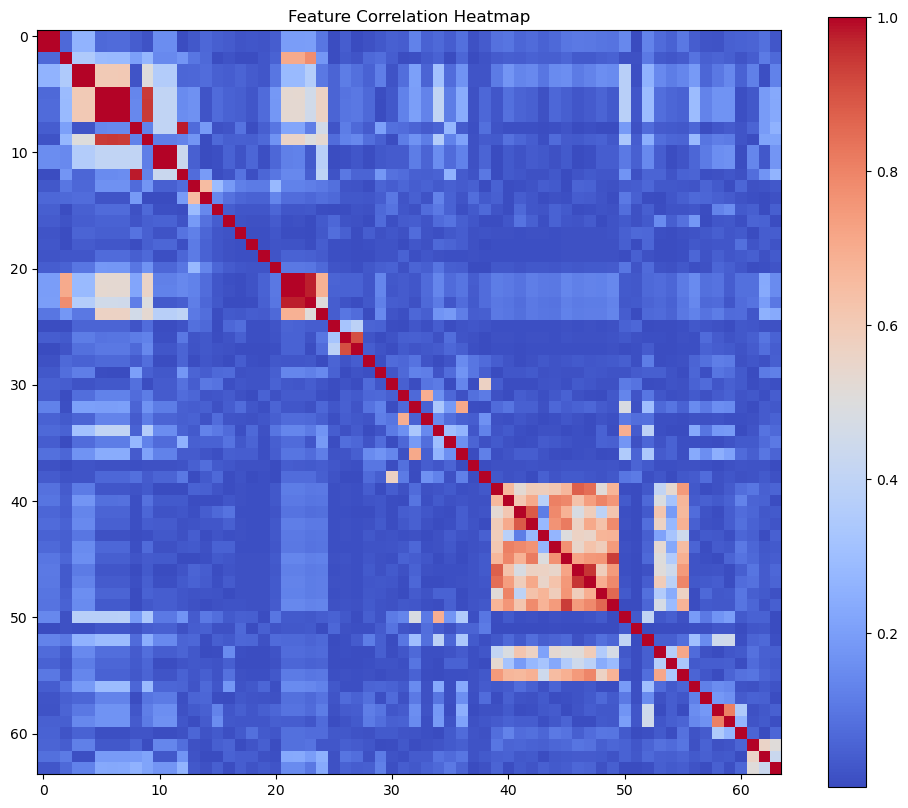

In [70]:
numeric_cols = [c for c, t in final_sameple_df.dtypes if t in ("double", "float", "int")]

sample_df = final_sameple_df.select(numeric_cols).toPandas()

corr = sample_df.corr().abs()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Feature Correlation Heatmap")
plt.colorbar()
plt.show()

In [71]:
threshold = 0.85

high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] > threshold] \
    .sort_values(by="Correlation", ascending=False)

high_corr_pairs

,Feature_1,Feature_2,Correlation
585,is_36_months,is_60_months,1.000000
0,initial_list_status_f,initial_list_status_w,1.000000
186,out_prncp,out_prncp_inv,0.999997
363,funded_amnt,funded_amnt_inv,0.999917
1113,total_pymnt,total_pymnt_inv,0.999883
305,loan_amnt,funded_amnt,0.999811
306,loan_amnt,funded_amnt_inv,0.999694
479,int_rate,sub_grade_num,0.978416
1114,total_pymnt,total_rec_prncp,0.974463
1155,total_pymnt_inv,total_rec_prncp,0.974126


|  # | Feature 1             | Feature 2             |     Corr | Giải thích                                                                | Giữ lại               | Lý do giữ                                                      | Cột bỏ                           |
| -: | --------------------- | --------------------- | -------: | ------------------------------------------------------------------------- | --------------------- | -------------------------------------------------------------- | -------------------------------- |
|  1 | initial_list_status_f | initial_list_status_w | 1.000000 | Hai dummy của cùng 1 thuộc tính `initial_list_status` — loại trừ nhau     | initial_list_status_w | Giữ 1 dummy làm đại diện cho trạng thái ban đầu                | initial_list_status_f            |
|  2 | is_36_months          | is_60_months          | 1.000000 | Hai dummy cho `term` (36 vs 60 tháng), luôn nghịch đảo                    | is_60_months          | Đại diện thời hạn vay (giữ 1 biến)                             | is_36_months                     |
|  3 | out_prncp             | out_prncp_inv         | 0.999998 | Giá trị gốc còn lại và phiên bản “inv” gần như trùng                      | out_prncp             | Biến gốc (outstanding principal) có ý nghĩa trực tiếp          | out_prncp_inv                    |
|  4 | funded_amnt           | funded_amnt_inv       | 0.999925 | Số tiền được cấp và biến cho nhà đầu tư hầu như giống nhau                | loan_amnt             | `loan_amnt` là biến chuẩn, đại diện quy mô khoản vay           | funded_amnt, funded_amnt_inv     |
|  5 | total_pymnt           | total_pymnt_inv       | 0.999873 | Tổng thanh toán thực tế và biến cho nhà đầu tư gần như trùng              | total_pymnt           | Tổng quát hơn (bao gồm gốc + lãi)                              | total_pymnt_inv                  |
|  6 | loan_amnt             | funded_amnt           | 0.999826 | Khoản vay và số tiền được tài trợ thường trùng hoặc rất gần nhau          | loan_amnt             | Đại diện trực tiếp cho quy mô khoản vay                        | funded_amnt                      |
|  7 | loan_amnt             | funded_amnt_inv       | 0.999720 | Tương tự: phiên bản “inv” của funded_amnt rất trùng với loan_amnt         | loan_amnt             | Biến chuẩn, dễ hiểu và ổn định                                 | funded_amnt_inv                  |
|  8 | int_rate              | sub_grade_num         | 0.979490 | `sub_grade_num` thường được gán dựa trên lãi suất / rủi ro (mã hóa)       | int_rate              | Có ý nghĩa tài chính trực tiếp và dễ giải thích                | sub_grade_num                    |
|  9 | total_pymnt           | total_rec_prncp       | 0.969947 | Tổng thanh toán chứa phần gốc đã thu hồi (total_rec_prncp)                | total_pymnt           | Bao quát hơn (gốc + lãi), thường là biến mục tiêu/quan tâm     | total_rec_prncp                  |
| 10 | total_pymnt_inv       | total_rec_prncp       | 0.969615 | Phiên bản “inv” của tổng thanh toán cũng tương đồng với phần gốc thu được | total_pymnt           | Dùng biến tổng chung để tránh trùng lặp                        | total_pymnt_inv, total_rec_prncp |
| 11 | funded_amnt           | installment           | 0.940933 | `installment` là hàm của khoản vay, lãi suất và term                      | loan_amnt             | Giữ `loan_amnt` làm đại diện quy mô; tránh giữ biến dẫn xuất   | funded_amnt, installment         |
| 12 | funded_amnt_inv       | installment           | 0.940823 | Tương tự — phiên bản “inv” và installment có mối liên hệ chặt             | loan_amnt             | Như trên                                                       | funded_amnt_inv, installment     |
| 13 | loan_amnt             | installment           | 0.940628 | `installment` phụ thuộc trực tiếp vào `loan_amnt`                         | loan_amnt             | Giữ biến gốc, loại bỏ biến dẫn xuất để tránh đa cộng tuyến     | installment                      |
| 14 | open_il_6m            | open_il_24m           | 0.928492 | Số tài khoản installment mở 6m thường là tập con của 24m                  | open_il_24m           | Bao quát hơn, phản ánh lịch sử dài hơn                         | open_il_6m                       |
| 15 | revol_bal             | total_rev_hi_lim      | 0.910534 | Số dư quay vòng và tổng hạn mức quay vòng liên quan (cùng nhóm)           | total_rev_hi_lim      | Hạn mức phản ánh khả năng tín dụng / sức chứa hơn là chỉ số dư | revol_bal                        |
| 16 | max_bal_bc            | all_util              | 0.905273 | Mức dư cao nhất trên thẻ và tỉ lệ sử dụng chung có quan hệ                | all_util              | `all_util` tổng quát hơn, phản ánh mức sử dụng trên mọi nguồn  | max_bal_bc                       |
| 17 | open_il_6m            | total_bal_il          | 0.887460 | Số tài khoản mở (6m) và tổng dư nợ installment có liên quan               | total_bal_il          | Tổng số dư phản ánh tải nợ thực tế tốt hơn                     | open_il_6m                       |
| 18 | open_il_24m           | total_bal_il          | 0.880775 | Tương tự: 24m là khoảng thời gian dài hơn so với 6m                       | total_bal_il          | Bao quát hơn, ổn định hơn trong thời gian dài                  | open_il_24m                      |
| 19 | il_util               | all_util              | 0.876893 | `il_util` (installment utilization) là một phần của `all_util`            | all_util              | `all_util` tổng quát, chứa nhiều nguồn sử dụng tín dụng        | il_util                          |
| 20 | open_il_12m           | open_il_24m           | 0.856780 | 12m là tập con của 24m (số tài khoản mở)                                  | open_il_24m           | Đại diện lịch sử mở tài khoản dài hơn                          | open_il_12m                      |


### Như vậy, các cột bị loại bỏ để tránh tương quan cao là: 
`annual_inc_joint`, `is_36_months`, `funded_amnt`, `funded_amnt_inv`, `total_pymnt_inv`, `sub_grade_num`, `total_rec_prncp`, `installment`, `open_rv_12m`, `il_util`


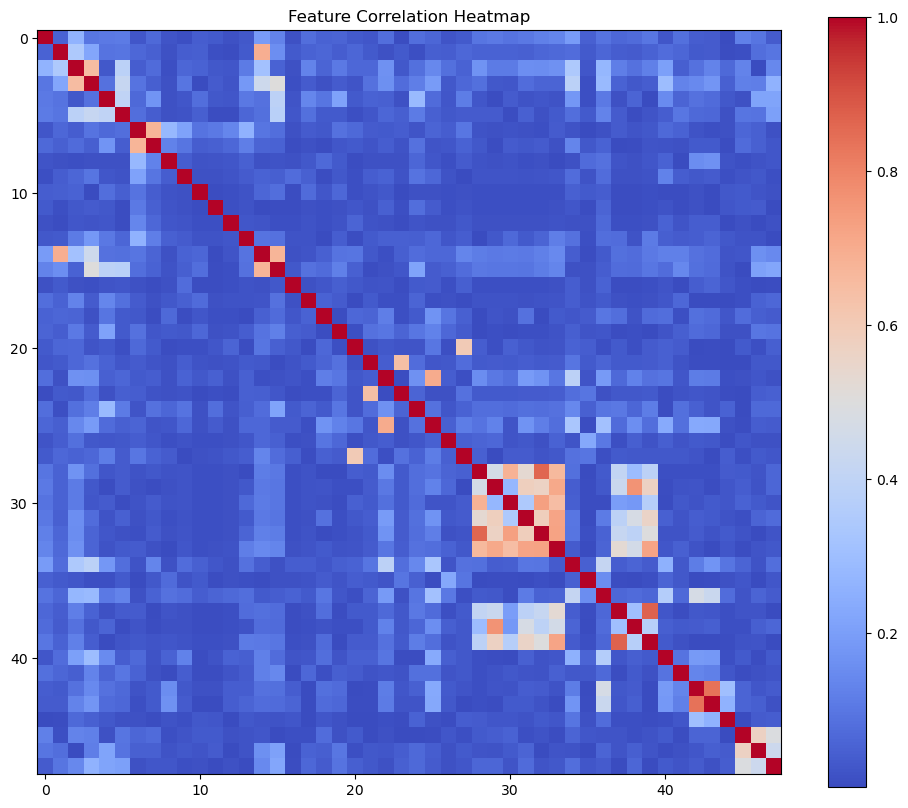

In [72]:
removed_cols = [
    "initial_list_status_f",
    "is_36_months",
    "out_prncp_inv",
    "funded_amnt",
    "funded_amnt_inv",
    "total_pymnt_inv",
    "total_rec_prncp",
    "installment",
    "open_il_6m",
    "revol_bal",
    "max_bal_bc",
    "open_il_12m",
    "open_rv_12m",
    "sub_grade_num",
    "collection_recovery_fee",
    "il_util"
]

final_cols = [c for c in numeric_cols if c not in removed_cols]

final_sameple_df = final_sameple_df.select(final_cols)

corr = final_sameple_df.toPandas().corr().abs()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Feature Correlation Heatmap")
plt.colorbar()
plt.show()

### Xuất dữ liệu ra csv và lưu trên hadoop

In [73]:
final_cols.append('loan_status_label')
final_df = loan_status_history_df \
    .join(loan_info_df, "id", "inner") \
    .join(repayment_summary_df, "id", "inner") \
    .join(credit_profile_df, "id", "inner") \
    .join(credit_account_detail_df, "id", "inner") \
    .join(borrower_profile_df, "member_id", "inner") \
    .select(final_cols)

In [74]:
final_df.write.csv(
    "hdfs://namenode:9000/bigdata/data/final_data",
    header=True,
    mode="overwrite"
)

In [75]:
spark.stop()